In [1]:
import sqlite3
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def nan_cols_stats(file, **kwargs):
    chunk_iter = pd.read_csv(file, **kwargs)
    na_val_counts = defaultdict(list)

    for chunk in chunk_iter:
        float_chunk = chunk.select_dtypes(float)
        for column in float_chunk.columns:
            na_val_counts[column].append(float_chunk.isna()[column].value_counts())
            
    for k, v in na_val_counts.items():
        conc = pd.concat(v)
        conc = conc.groupby(conc.index).sum()
        na_val_counts[k] = conc

    na_val_counts = pd.DataFrame(na_val_counts).T
    na_val_counts.columns = ['not nulls', 'nulls']
    na_val_counts.sort_values('nulls', ascending=False, inplace=True)
    return na_val_counts

def uniq_vals_stats(file, **kwargs):
    chunk_iter = pd.read_csv(file, **kwargs)
    uniq_col_vals = defaultdict(list)
    for chunk in chunk_iter:
        str_chunk = chunk.select_dtypes('object')
        for col in str_chunk.columns:
            val_count = str_chunk[col].value_counts()
            uniq_col_vals[col].append(val_count)

    col_stats = defaultdict(dict)

    for column, series in uniq_col_vals.items():
        series = pd.concat(series)
        series = series.groupby(series.index).sum()
        uniq_val_rate = len(series)/series.sum()
        no_unique = len(series)
        tot = series.sum()
        percent_uniq = round(no_unique/tot*100, 3)
        col_stats[column]["unique_vals"] = no_unique
        col_stats[column]["total_vals"] = tot
        col_stats[column]["% of unique values"] = percent_uniq
    col_stats = pd.DataFrame(col_stats).T.astype({'% of unique values': float,
                                                  'total_vals': int,
                                                  'unique_vals': int})
    col_stats = col_stats.sort_values('% of unique values', ascending=False)
    return col_stats

def mem_use(file, **kwargs):
    chunk_iter = pd.read_csv(file, **kwargs)
    mem_usage_across = []
    column_types = defaultdict(dict)
    for idx, chunk in enumerate(chunk_iter):
        chunk_mem_use = chunk.memory_usage(deep=True).sum()/(2**20)
        mem_usage_across.append(chunk_mem_use)
        column_types[idx]['int_cols'] = chunk.select_dtypes('int').shape[1]
        column_types[idx]['float_cols'] = chunk.select_dtypes('float').shape[1]
        column_types[idx]['string_cols'] = chunk.select_dtypes('object').shape[1]
        column_types[idx]['memory_usage (MB)'] = round(chunk_mem_use, 2)
    print('total memory usage:', round(sum(mem_usage_across), 2), 'MB')
    plt.figure(figsize=(14,8))
    plt.title('memory usage of chunks')
    plt.hist(mem_usage_across);
    stats = pd.DataFrame(column_types).T.astype({'int_cols': int,
                                                'string_cols': int,
                                                'float_cols': int})
    stats.index.name='chunk'
    return stats

def null_counts(file , **kwargs):
    chunk_iter = pd.read_csv(file, **kwargs)
    na_counts = defaultdict(list)
    for chunk in chunk_iter:
        na_count = chunk.isna()
        for col in chunk.columns:
            na_counts[col].append(na_count[col].value_counts())

    for col, na_counts_list in na_counts.items():
        counts = pd.concat(na_counts_list)
        counts = counts.groupby(counts.index).sum()
        na_counts[col] = counts

    na_counts = pd.DataFrame(na_counts).T
    na_counts.columns=['not nulls', 'nulls']
    na_counts.sort_values('nulls', ascending=False, inplace=True)
    na_counts.index.name = 'columns'
    return na_counts

In [3]:
!ls -lah crunchbase-investments.csv | awk '{ print $5 }'

9,9M


In [4]:
nan_cols_stats('crunchbase-investments.csv', chunksize=5000, encoding = 'ISO-8859-1')

,not nulls,nulls
investor_category_code,NaN,47870.0
investor_country_code,NaN,7870.0
investor_state_code,NaN,7870.0
investor_city,NaN,7870.0
raised_amount_usd,49271.0,3599.0
funded_year,4997.0,3.0


In [5]:
uniq_vals_stats('crunchbase-investments.csv', chunksize=5000, encoding = 'ISO-8859-1')

,unique_vals,total_vals,% of unique values
company_permalink,11573,52869,21.890
company_name,11573,52869,21.890
investor_permalink,10552,52868,19.959
investor_name,10465,52868,19.795
funded_at,2808,52867,5.311
investor_city,990,40390,2.451
company_city,1229,52337,2.348
investor_category_code,33,2443,1.351
investor_region,585,52868,1.107
company_region,546,52869,1.033


total memory usage: 56.99 MB


,int_cols,float_cols,string_cols,memory_usage (MB)
chunk,,,,
0,1,1,18,5.58
1,1,2,17,5.53
2,1,2,17,5.54
3,1,2,17,5.53
4,1,2,17,5.52
5,1,2,17,5.55
6,0,3,17,5.53
7,1,2,17,5.51
8,1,2,17,5.40


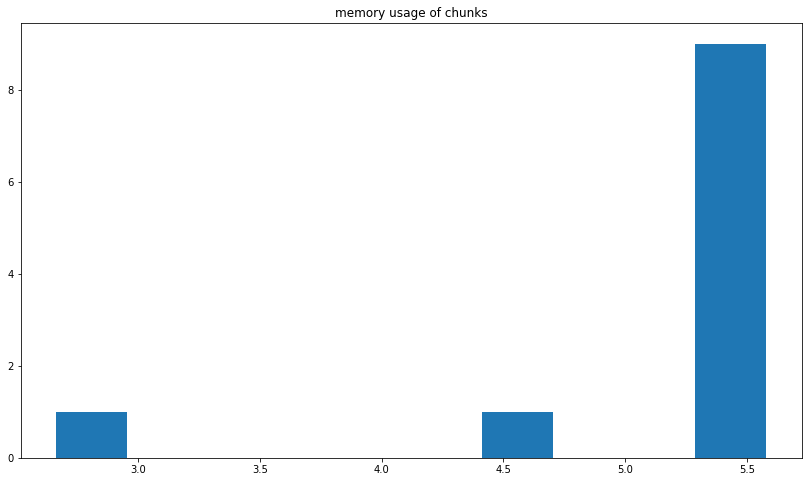

In [6]:
mem_use('crunchbase-investments.csv', chunksize=5000, encoding = 'ISO-8859-1')

In [7]:
null_counts('crunchbase-investments.csv', chunksize=5000, encoding = 'ISO-8859-1')

,not nulls,nulls
columns,,
investor_category_code,2443,50427
investor_state_code,36061,16809
investor_city,40390,12480
investor_country_code,40869,12001
raised_amount_usd,49271,3599
company_category_code,52227,643
company_city,52337,533
company_state_code,52378,492
funding_round_type,52867,3


### Which columns are irrelevant for analysis

In [8]:
df = pd.read_csv('crunchbase-investments.csv',
                 nrows=20,
                 encoding='ISO-8859-1')

In [9]:
df

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000.0
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000.0
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000.0
3,/company/zoopshop,ZoopShop,software,USA,OH,Columbus,columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-02-15,2012-02,2012-Q1,2012,20000.0
4,/company/efuneral,eFuneral,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2011-09-08,2011-09,2011-Q3,2011,20000.0
5,/company/tackk,Tackk,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-02-01,2012-02,2012-Q1,2012,20000.0
6,/company/acclaimd,Acclaimd,analytics,USA,OH,Columbus,Columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-06-01,2012-06,2012-Q2,2012,20000.0
7,/company/acclaimd,Acclaimd,analytics,USA,OH,Columbus,Columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-08-07,2012-08,2012-Q3,2012,70000.0
8,/company/toviefor,ToVieFor,ecommerce,USA,NY,New York,New York,/company/2010-nyu-stern-business-plan-competition,2010 NYU Stern Business Plan Competition,NaN,NaN,NaN,unknown,NaN,angel,2010-04-01,2010-04,2010-Q2,2010,75000.0
9,/company/ohk-labs,OHK Labs,sports,USA,FL,Palm Beach,Boca Raton,/company/22hundred-group,22Hundred Group,NaN,NaN,NaN,unknown,NaN,angel,2011-09-01,2011-09,2011-Q3,2011,100000.0


In [10]:
irr_cols = {'company_permalink', 'company_region','investor_permalink', 
            'investor_region', 'investor_category_code','funded_month', 
            'funded_year'}
use_cols = []
for col in df.columns:
    if col not in irr_cols:
        use_cols.append(col)

In [28]:
types = {col: 'category' for col in df.select_dtypes('object').columns}
types['raised_amount_usd'] = 'float32'

In [31]:
df = pd.read_csv('crunchbase-investments.csv',
                 nrows=20,
                 encoding='ISO-8859-1', 
                 usecols=use_cols,
                 parse_dates=['funded_at'],
                dtype=types)

total memory usage: 34.48 MB


,int_cols,float_cols,string_cols,memory_usage (MB)
chunk,,,,
0,0,0,11,3.32
1,0,0,11,3.40
2,0,0,11,3.40
3,0,0,11,3.40
4,0,0,11,3.38
5,0,0,11,3.41
6,0,0,11,3.39
7,0,0,11,3.38
8,0,0,11,3.29


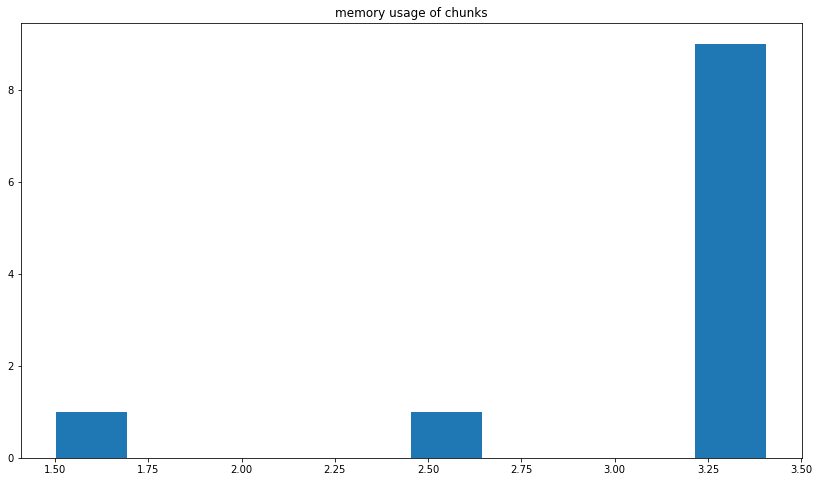

In [32]:
mem_use('crunchbase-investments.csv',
        chunksize=5000,
        encoding='ISO-8859-1', 
        usecols=use_cols,
        parse_dates=['funded_at'],
        dtype=types)

In [35]:
def save_to_db(file , **kwargs):
    conn = sqlite3.connect('fundraising.db')
    chunk_iter = pd.read_csv(file, **kwargs)
    for chunk in chunk_iter:
        chunk.to_sql('fundraising', conn, if_exists='append')

In [36]:
save_to_db('crunchbase-investments.csv',
        chunksize=5000,
        encoding='ISO-8859-1', 
        usecols=use_cols,
        parse_dates=['funded_at'],
        dtype=types)

In [37]:
conn = sqlite3.connect('fundraising.db')
pd.read_sql('PRAGMA table_info(fundraising)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,company_name,TEXT,0,None,0
2,2,company_category_code,TEXT,0,None,0
3,3,company_country_code,TEXT,0,None,0
4,4,company_state_code,TEXT,0,None,0
5,5,company_city,TEXT,0,None,0
6,6,investor_name,TEXT,0,None,0
7,7,investor_country_code,TEXT,0,None,0
8,8,investor_state_code,TEXT,0,None,0
9,9,investor_city,TEXT,0,None,0


In [38]:
!wc -l fundraising.db

11170 fundraising.db


In [43]:
!ls -lh fundraising.db

-rw-r--r-- 1 przemyslaw przemyslaw 6,9M mar 26 23:21 fundraising.db


### Which category was most attractive

In [44]:
cat_counts = pd.read_sql("""
    select 
    company_category_code,
    count(distinct company_name) as companies_no 
    from fundraising 
    group by company_category_code 
    order by companies_no desc""", conn)

In [45]:
cat_counts

,company_category_code,companies_no
0,software,1784
1,web,1183
2,biotech,1041
3,enterprise,849
4,mobile,774
5,advertising,576
6,games_video,476
7,cleantech,457
8,ecommerce,445
9,hardware,352


### Which investors spent the most money (across all companies)

In [47]:
inv_spend = pd.read_sql("""
    select investor_name,
    sum(raised_amount_usd) total_usd_spent 
    from fundraising 
    group by investor_name 
    order by total_usd_spent desc""", conn)

In [48]:
inv_spend

,investor_name,total_usd_spent
0,Kleiner Perkins Caufield & Byers,1.121783e+10
1,New Enterprise Associates,9.692542e+09
2,Accel Partners,6.472126e+09
3,Goldman Sachs,6.375459e+09
4,Sequoia Capital,6.039402e+09
...,...,...
10461,glendonTodd Capital,NaN
10462,iCamp,NaN
10463,iTACTIC,NaN
10464,mike schell,NaN


### Which investors spent the most money (per company)

In [49]:
inv_spend_per_stup = pd.read_sql("""
    select 
    investor_name,
    company_name,
    sum(raised_amount_usd) total_usd_spent 
    from fundraising 
    group by investor_name, company_name 
    order by total_usd_spent desc""", conn)

In [50]:
inv_spend_per_stup

,investor_name,company_name,total_usd_spent
0,Comcast,Clearwire,5.620000e+09
1,Intel,Clearwire,5.620000e+09
2,Time Warner,Clearwire,5.620000e+09
3,BrightHouse,Clearwire,4.700000e+09
4,Google,Clearwire,3.200000e+09
...,...,...,...
40963,reinmkr capital,GazeHawk,NaN
40964,reinmkr capital,Voicendo,NaN
40965,vSpring Capital,BioMicro Systems,NaN
40966,ventureblue Capital,Mangia,NaN


### Which funding round was the most popular?

In [51]:
funding_round = pd.read_sql("""
    select 
    funding_round_type,
    sum(raised_amount_usd) total_usd_spent 
    from fundraising 
    group by funding_round_type 
    order by total_usd_spent desc""", conn)

In [52]:
funding_round

,funding_round_type,total_usd_spent
0,series-c+,2.657535e+11
1,venture,1.305565e+11
2,series-b,1.283268e+11
3,series-a,8.654215e+10
4,post-ipo,3.091760e+10
5,other,1.850726e+10
6,private-equity,1.615988e+10
7,angel,4.962075e+09
8,crowdfunding,6.491500e+06
9,None,NaN
